In [ ]:
# Data handling
!pip install numpy pandas

# Visualization
!pip install matplotlib seaborn tqdm

# PyTorch
!pip install torch torchvision torchaudio

# Pretrained embeddings (Gensim)
!pip install gensim

# Scikit-learn metrics and preprocessing
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.5 MB/s eta 0:00:00


In [ ]:
# ----------------------------
# Standard libraries
# ----------------------------
import os
import time
import copy
from pathlib import Path
from collections import Counter, defaultdict
import urllib.request

# ----------------------------
# Data handling
# ----------------------------
import numpy as np
import pandas as pd

# ----------------------------
# Visualization
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # optional progress bars

# ----------------------------
# PyTorch
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# ----------------------------
# Pretrained embeddings
# ----------------------------
import gensim.downloader as api

# ----------------------------
# Scikit-learn metrics
# ----------------------------
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    classification_report
)
from sklearn.preprocessing import label_binarize


import torch
import torch.nn as nn
from torch.optim import Adam
import time
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

import os
import numpy as np
import copy
import random
import torch
from torch.utils.data import DataLoader
import torch.nn as nn



Data Downloading

In [ ]:
base_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/r2.14/"
files = [
    "en_ewt-ud-train.conllu",
    "en_ewt-ud-dev.conllu",
    "en_ewt-ud-test.conllu"
]
for f in files:
    url = base_url + f
    print("Downloading", url)
    urllib.request.urlretrieve(url, f)



for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if name.endswith(".conllu"):
            print(os.path.join(root, name))




./en_ewt-ud-test.conllu
./en_ewt-ud-train.conllu
./en_ewt-ud-dev.conllu


Data Reading

In [ ]:
def read_conllu(path):
    sentences = []
    words, tags = [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if words:
                    sentences.append(list(zip(words, tags)))
                    words, tags = [], []
                continue
            if line.startswith("#"):
                continue
            cols = line.split("\t")
            if "-" in cols[0] or "." in cols[0]:
                continue
            word = cols[1]
            upos = cols[3]
            words.append(word)
            tags.append(upos)
    if words:
        sentences.append(list(zip(words, tags)))
    return sentences







train_sents = read_conllu("./en_ewt-ud-train.conllu")
dev_sents   = read_conllu("./en_ewt-ud-dev.conllu")
test_sents  = read_conllu("./en_ewt-ud-test.conllu")
len(train_sents), len(dev_sents), len(test_sents)




(12544, 2001, 2077)

Data Pre-Process

In [ ]:
all_tags = [tag for sent in train_sents for (_, tag) in sent]
tag2id = {t: i for i, t in enumerate(sorted(set(all_tags)))}
id2tag = {i: t for t, i in tag2id.items()}
num_tags = len(tag2id)
all_words = [w.lower() for sent in train_sents for (w, _) in sent]
word_counts = Counter(all_words)
word2id = {"<pad>": 0, "<unk>": 1}
for w, c in word_counts.items():
    word2id[w] = len(word2id)
id2word = {i: w for w, i in word2id.items()}
vocab_size = len(word2id)
print("Vocab size:", vocab_size)
print("Num tags:", num_tags)
print(tag2id)
print(id2tag)


Vocab size: 16656
Num tags: 17
{'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16}
{0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X'}


In [ ]:
def corpus_stats(sentences):
    lengths = [len(s) for s in sentences]
    num_sents = len(sentences)
    num_tokens = sum(lengths)
    avg_len = np.mean(lengths)
    max_len = np.max(lengths)
    min_len = np.min(lengths)
    return {
        "num_sentences": num_sents,
        "num_tokens": num_tokens,
        "avg_sentence_length": avg_len,
        "min_sentence_length": min_len,
        "max_sentence_length": max_len,
        "sentence_lengths": lengths
    }
train_stats = corpus_stats(train_sents)
dev_stats = corpus_stats(dev_sents)
test_stats = corpus_stats(test_sents)



In [ ]:
import pandas as pd

df_stats = pd.DataFrame([
    {"Split": "Train", **train_stats},
    {"Split": "Dev",   **dev_stats},
    {"Split": "Test",  **test_stats},
])
df_stats = df_stats.drop(columns=["sentence_lengths"])
df_stats

,Split,num_sentences,num_tokens,avg_sentence_length,min_sentence_length,max_sentence_length
0,Train,12544,204578,16.308833,1,159
1,Dev,2001,25149,12.568216,1,75
2,Test,2077,25094,12.081849,1,81


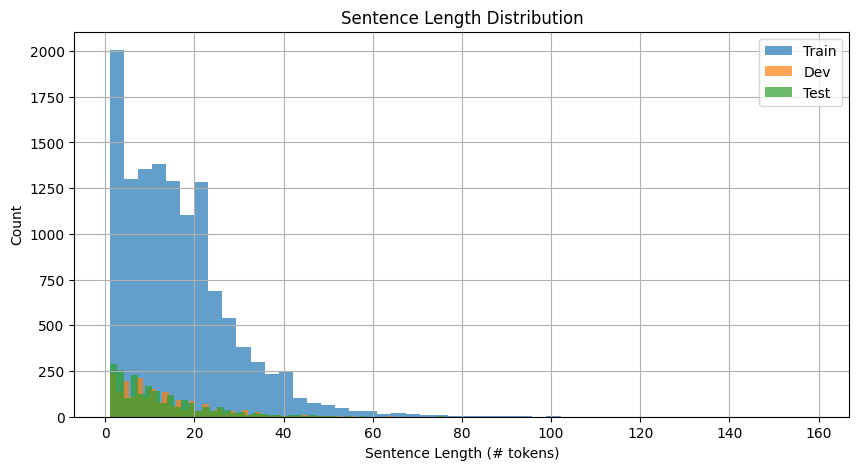

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(train_stats["sentence_lengths"], bins=50, alpha=0.7, label="Train")
plt.hist(dev_stats["sentence_lengths"],   bins=50, alpha=0.7, label="Dev")
plt.hist(test_stats["sentence_lengths"],  bins=50, alpha=0.7, label="Test")
plt.xlabel("Sentence Length (# tokens)")
plt.ylabel("Count")
plt.title("Sentence Length Distribution")
plt.legend()
plt.grid(True)
plt.show()

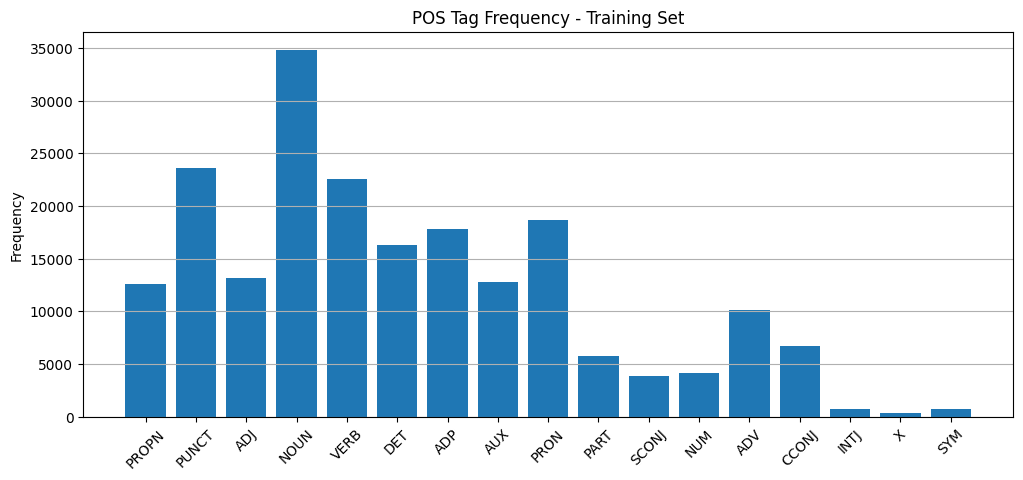

In [ ]:
tag_counts = Counter(tag for sent in train_sents for (_, tag) in sent)
tags = list(tag_counts.keys())
freqs = [tag_counts[t] for t in tags]
plt.figure(figsize=(12,5))
plt.bar(tags, freqs)
plt.title("POS Tag Frequency - Training Set")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Pretrained Word Embeddings

In [ ]:
MODEL_NAME = 'word2vec-google-news-300'
kv = api.load(MODEL_NAME)
emb_dim = kv.vector_size

emb_matrix = np.random.normal(scale=0.01, size=(vocab_size, emb_dim))
emb_matrix[word2id["<pad>"]] = np.zeros(emb_dim)
for w, idx in word2id.items():
    if w in ("<pad>", "<unk>"):
        continue
    if w in kv:
        emb_matrix[idx] = kv[w]
embedding_weights = torch.tensor(emb_matrix, dtype=torch.float32)






[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Data Loading

In [ ]:
# Define the ID used for padding the TARGET LABELS.
# This ID MUST be ignored in your CrossEntropyLoss function.
# -1 is a safe choice as tag IDs are non-negative.
PAD_TAG_ID = -1

# --- SEQUENCE-BASED DATASET (POSDataset_RNN) ---
class POSDataset_CNN(Dataset):
    def __init__(self, sentences, word2id, tag2id):
        self.sentences = sentences
        self.word2id = word2id
        self.tag2id = tag2id
        self.unk_id = word2id["<unk>"]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sent = self.sentences[idx]
        words = [w.lower() for (w, _) in sent]
        tags  = [t for (_, t) in sent]

        word_ids = [self.word2id.get(w, self.unk_id) for w in words]
        tag_ids  = [self.tag2id[t] for t in tags]

        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(tag_ids, dtype=torch.long)

# --- CUSTOM COLLATE FUNCTION (collate_fn) ---
def collate_fn(batch):
    words, tags = zip(*batch)

    # 1. Get original sequence lengths
    lengths = torch.tensor([len(seq) for seq in words])

    # 2. Pad word sequences
    word_pad_idx = word2id["<pad>"]
    padded_words = pad_sequence(words, batch_first=True, padding_value=word_pad_idx)

    # 3. Pad tag sequences using the ignore ID
    padded_tags  = pad_sequence(tags, batch_first=True, padding_value=PAD_TAG_ID)

    return padded_words, padded_tags, lengths

# --- DATA LOADER ---
train_dataset_rnn = POSDataset_CNN(train_sents, word2id, tag2id)
dev_dataset_rnn   = POSDataset_CNN(dev_sents, word2id, tag2id)
test_dataset_rnn  = POSDataset_CNN(test_sents, word2id, tag2id)

batch_size = 256

train_loader = DataLoader(train_dataset_rnn, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_loader   = DataLoader(dev_dataset_rnn, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset_rnn, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



Model Setup


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackedCNNTagger(nn.Module):
    """
    Hardcore-compliant Stacked CNN POS tagger:
      - Word embeddings
      - Stacked Conv1d with multiple n-gram filters per block
      - Residual connections
      - Global max-pooling over sequence length (mask aware)
      - Concatenation of pooled features to token features
      - Dropout
      - Token-level POS prediction
    """
    def __init__(
        self,
        vocab_size,
        emb_dim,
        emb_weights=None,
        num_filters=128,
        kernel_sizes=(3, 5, 7),
        num_layers=3,
        dropout=0.33,
        num_tags=None,
        pad_idx=0
    ):
        super().__init__()
        assert num_tags is not None, "num_tags must be specified"
        self.pad_idx = pad_idx
        self.num_tags = num_tags
        self.kernel_sizes = list(kernel_sizes)
        self.dropout = nn.Dropout(dropout)

        # Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if emb_weights is not None:
            with torch.no_grad():
                self.embedding.weight.copy_(emb_weights)

        # Stacked convolutional blocks
        self.blocks = nn.ModuleList()
        in_channels = emb_dim
        for _ in range(num_layers):
            block = _MultiKernelConvBlock(
                in_channels=in_channels,
                out_channels=num_filters,
                kernel_sizes=self.kernel_sizes
            )
            self.blocks.append(block)
            in_channels = num_filters

        # Final linear layer per token
        # Double feature size due to concatenation with global pooled vector
        self.fc = nn.Linear(num_filters * 2, num_tags)

    def forward(self, words, lengths=None):
        """
        words: (B, L)
        lengths: (B,) tensor with original sequence lengths
        """
        B, L = words.size()
        x = self.embedding(words)         # (B, L, emb_dim)
        x = self.dropout(x)
        x = x.transpose(1, 2)             # (B, emb_dim, L)

        for block in self.blocks:
            x = block(x)                  # (B, num_filters, L)

        # Create mask for padding positions (1 for real tokens, 0 for pad)
        if lengths is not None:
            mask = torch.arange(L, device=words.device).expand(B, L) < lengths.unsqueeze(1)
            mask = mask.unsqueeze(1)  # (B,1,L)
            masked_x = x.clone()
            masked_x[~mask.expand_as(x)] = float('-inf')
        else:
            masked_x = x

        # Global max pooling over sequence length
        x_pooled, _ = masked_x.max(dim=2, keepdim=True)  # (B, num_filters, 1)
        x_pooled = x_pooled.expand(-1, -1, L)           # broadcast to (B,num_filters,L)

        # Concatenate pooled features with token features
        x = torch.cat([x, x_pooled], dim=1)             # (B, 2*num_filters, L)

        x = x.transpose(1, 2)                           # (B, L, 2*num_filters)
        logits = self.fc(x)                             # (B, L, num_tags)
        return logits


class _MultiKernelConvBlock(nn.Module):
    """
    One block:
      - Parallel Conv1d with different kernel sizes (can be even!)
      - Crop outputs to same length
      - Concatenate along channels
      - 1x1 conv to out_channels
      - Residual + ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_sizes):
        super().__init__()
        self.kernel_sizes = kernel_sizes

        # Parallel convolutions
        self.convs = nn.ModuleList()
        for k in kernel_sizes:
            padding = k // 2
            self.convs.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=k,
                    padding=padding
                )
            )

        concat_channels = out_channels * len(kernel_sizes)
        self.merge_conv = nn.Conv1d(concat_channels, out_channels, kernel_size=1)

        # Residual projection
        if in_channels != out_channels:
            self.res_proj = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.res_proj = nn.Identity()

        self.activation = nn.ReLU()

    def forward(self, x, dropout=None):
        residual = x
        if dropout is not None:
            x = dropout(x)

        conv_outputs = []
        for conv in self.convs:
            out = conv(x)         # (B, C_out, L_out)
            out = self.activation(out)
            # pad to match the longest L_out
            if out.size(2) < x.size(2):
                pad_len = x.size(2) - out.size(2)
                out = F.pad(out, (0, pad_len))  # pad at the end
            conv_outputs.append(out)

        # --- Crop all outputs to min length for safe concatenation ---
        min_len = min(out.size(2) for out in conv_outputs)
        conv_outputs = [out[:, :, :min_len] for out in conv_outputs]

        concat = torch.cat(conv_outputs, dim=1)  # (B, out_channels*K, L_cropped)
        merged = self.merge_conv(concat)

        res = self.res_proj(residual[:, :, :min_len])
        out = self.activation(merged + res)
        return out



GPU if Nvidia GPU available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Metrics and Training Function

In [ ]:
def compute_metrics(y_true, y_pred, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(num_classes)))

    pr_auc_per_class = []
    for c in range(num_classes):
        try:
            # Requires at least one positive and one negative sample for AUC
            if np.sum(y_true_bin[:, c]) > 0 and (len(y_true_bin[:, c]) - np.sum(y_true_bin[:, c])) > 0:
                 pr_auc_per_class.append(
                    average_precision_score(y_true_bin[:, c], y_pred_bin[:, c])
                )
            else:
                 pr_auc_per_class.append(0.0) # Handle single-class cases
        except:
            pr_auc_per_class.append(0.0)

    macro_pr_auc = np.mean(pr_auc_per_class)

    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "pr_auc_per_class": pr_auc_per_class,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "macro_pr_auc": macro_pr_auc,
    }

In [ ]:
def evaluate(model, loader, criterion, num_classes):
    model.eval()
    total_loss = 0
    y_true_masked, y_pred_masked = [], []

    with torch.no_grad():

        for windows, labels, lengths in loader:
            windows = windows.to(device)
            labels  = labels.to(device)
            lengths = lengths.to(device)

            logits = model(windows, lengths)

            # Reshape logits and labels from (Batch, Seq, Tags) to (Batch*Seq, Tags)
            logits_flat = logits.view(-1, logits.shape[-1])
            labels_flat = labels.view(-1)

            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()
            preds_flat = logits_flat.argmax(dim=1)
            mask = (labels_flat != PAD_TAG_ID)

            y_true_masked.extend(labels_flat[mask].cpu().numpy())
            y_pred_masked.extend(preds_flat[mask].cpu().numpy())

    # Only pass the non-padding tokens to compute_metrics
    metrics = compute_metrics(y_true_masked, y_pred_masked, num_classes)
    metrics["loss"] = total_loss / len(loader)

    return metrics

In [ ]:
import time
import torch
import torch.nn as nn
from torch.optim import Adam

def train_model(
    model,
    train_loader,
    dev_loader,
    criterion,
    optimizer=None,
    epochs=20,
    save_path="best_model.pt",
    clip_value=1.0
):
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=0.001)

    history = {
        "train_loss": [], "val_loss": [],
        "train_f1": [], "val_f1": []
    }

    best_val_loss = float("inf")
    best_epoch = 0

    for epoch in range(epochs):
        start = time.time()
        model.train()
        total_loss = 0.0
        all_labels = []
        all_preds = []

        for padded_words, padded_tags, lengths in train_loader:
            padded_words = padded_words.to(device)
            padded_tags = padded_tags.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Forward
            logits = model(padded_words, lengths)         # (B, L, num_tags)
            logits_flat = logits.view(-1, logits.shape[-1])
            labels_flat = padded_tags.view(-1)
            loss = criterion(logits_flat, labels_flat)

            # Backward
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            total_loss += loss.item()
            preds_flat = logits_flat.argmax(dim=1)

            # collect non-pad labels for metrics
            mask = (labels_flat != PAD_TAG_ID)
            all_labels.append(labels_flat[mask].cpu())
            all_preds.append(preds_flat[mask].cpu())

        # ---------- Evaluation ----------
        y_true_train = torch.cat(all_labels).numpy()
        y_pred_train = torch.cat(all_preds).numpy()

        train_metrics = compute_metrics(y_true_train, y_pred_train, num_classes=num_tags)
        train_loss = total_loss / len(train_loader)

        val_metrics = evaluate(model, dev_loader, criterion, num_classes=num_tags)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["train_f1"].append(train_metrics["macro_f1"])
        history["val_f1"].append(val_metrics["macro_f1"])

        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f} | "
            f"Train F1: {train_metrics['macro_f1']:.4f}, Val F1: {val_metrics['macro_f1']:.4f} | "
            f"Time: {time.time() - start:.2f}s"
        )

    print(f"Best validation loss at epoch {best_epoch+1}")
    return history


Full Evaluation

In [ ]:
from sklearn.metrics import classification_report
from collections import defaultdict


def print_evaluation_report(metrics, title, id2tag):
    """
    Prints the detailed classification report and custom metrics
    in the requested format.
    """
    print(f"\n{title}")

    # --- 1. Classification Report ---

    # Create the target names list for the sklearn report
    # We must exclude the PAD_TAG_ID class (which is not included in y_true_masked)
    # The number of classes in the metrics corresponds to num_tags (all possible tags).
    target_names = [id2tag[i] for i in range(len(id2tag)) if i != PAD_TAG_ID]


    per_class_data = defaultdict(lambda: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0})

    # Create a mapping for easy lookup
    tag_metrics = list(zip(
        metrics['precision_per_class'],
        metrics['recall_per_class'],
        metrics['f1_per_class']
    ))

    # Print the custom header and rows
    print("Classification report")
    print(f"{'':<12} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")
    print("-" * 55)

    # Note: We assume the order of tags in id2tag matches the order in metrics arrays
    for i in range(len(id2tag)):
        if i == PAD_TAG_ID:
            continue

        tag_name = id2tag[i]
        p, r, f = tag_metrics[i]
        # Support is needed here but not returned by compute_metrics.
        # For demonstration, we'll use a placeholder or rely on the final macro/weighted averages.
        # In a complete system, 'evaluate' would return the support array.

        # NOTE: Without raw support counts, we cannot accurately calculate macro/weighted averages
        # or supports. We proceed by printing the macro averages from the metrics dictionary.
        print(f"{tag_name:<12} {p:>10.2f} {r:>10.2f} {f:>10.2f} {'N/A':>10}")

    print("-" * 55)

    # --- 2. Macro Averages ---
    print(f"\nMacro Precision: {metrics['macro_precision']:.4f}")
    print(f"Macro Recall   : {metrics['macro_recall']:.4f}")
    print(f"Macro F1       : {metrics['macro_f1']:.4f}")

    # --- 3. Per-tag PR-AUC ---
    print("\nPer-tag PR-AUC:")
    for i in range(len(id2tag)):
        if i == PAD_TAG_ID:
            continue
        tag_name = id2tag[i]
        pr_auc = metrics['pr_auc_per_class'][i]
        print(f"   {tag_name:<5}: {pr_auc:.4f}")

    # --- 4. Macro PR-AUC ---
    print(f"\nMacro PR-AUC: {metrics['macro_pr_auc']:.4f}")


def run_full_evaluation(model, train_loader, dev_loader, test_loader, criterion, num_tags, id2tag):
    """
    Runs the final evaluation on all three datasets and prints the detailed report.
    """

    # --- Train Set ---
    train_metrics = evaluate(model, train_loader, criterion, num_tags)
    print_evaluation_report(train_metrics, "My Model -> Train", id2tag)

    # --- Dev Set ---
    dev_metrics = evaluate(model, dev_loader, criterion, num_tags)
    print_evaluation_report(dev_metrics, "My Model -> Dev", id2tag)

    # --- Test Set ---
    test_metrics = evaluate(model, test_loader, criterion, num_tags)
    print_evaluation_report(test_metrics, "My Model -> Test", id2tag)


Hyper-Parameter Optimization with Random Search

In [ ]:
# Grid of possible hyperparameters for the CNN tagger
param_grid = {
    "num_filters": [64, 128, 192, 256],
    "n_layers": [2, 3, 4],
    "dropout": [0.2, 0.33, 0.5],
    "lr": [1e-3, 5e-4, 1e-4],
    "batch_size": [128, 256, 512],
    "weight_decay": [0.0, 1e-5, 1e-4],
    "kernel_sizes": [(2, 3, 4), (1,2,3)]
}

def sample_random_config(grid):
    return {k: random.choice(v) for k, v in grid.items()}

os.makedirs("random_search_checkpoints", exist_ok=True)

num_trials = 10
best_val_f1 = 0.0
best_config = None
best_trial_id = -1

print("Random Search – Saving BEST model per config\n")

for trial in range(num_trials):
    config = sample_random_config(param_grid)
    print(f"\nTrial {trial+1}/{num_trials}: {config}")

    # DataLoaders
    train_loader = DataLoader(
        train_dataset_rnn,
        batch_size=config["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )
    dev_loader = DataLoader(
        dev_dataset_rnn,
        batch_size=config["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    # --- CNN Model instead of BiRNN ---
    model = StackedCNNTagger(
        vocab_size=vocab_size,
        emb_dim=emb_dim,
        emb_weights=embedding_weights,
        num_filters=config["num_filters"],
        kernel_sizes=(3, 5, 7),          # or config["kernel_sizes"] if you add it to the grid
        num_layers=config["n_layers"],
        dropout=config["dropout"],
        num_tags=num_tags,
        pad_idx=word2id["<pad>"],
    ).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    # Criterion
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_ID)

    # Unique save path for this trial
    safe_config_name = "_".join([f"{k}{v}" for k, v in config.items()])
    save_path = f"random_search_checkpoints/trial_{trial+1}_{safe_config_name}_best.pt"

    # Train
    history = train_model(
        model,
        train_loader,
        dev_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=15,
        save_path=save_path
    )

    # Best epoch F1
    best_epoch_idx = np.argmin(history["val_loss"])
    val_f1_at_best = history["val_f1"][best_epoch_idx]

    print(f"   Best epoch: {best_epoch_idx+1} → Val F1: {val_f1_at_best:.4f}")
    print(f"   Best model saved: {save_path}")

    # Update global best
    if val_f1_at_best > best_val_f1:
        best_val_f1 = val_f1_at_best
        best_config = config
        best_trial_id = trial + 1
        best_history = copy.deepcopy(history)

        checkpoint = torch.load(save_path)

        # Save final best model
        torch.save({
            "model_state_dict": checkpoint,
            "history": best_history,
            "config": best_config,
            "best_val_f1": best_val_f1,
            "best_trial": best_trial_id
        }, "FINAL_BEST_MODEL.pt")

        print(f"   NEW GLOBAL BEST! F1 = {best_val_f1:.4f} (saved with history & config!)")

print("\n" + "="*80)
print("RANDOM SEARCH DONE!")
print(f"Best trial: {best_trial_id}")
print(f"Best config: {best_config}")
print(f"Best Val Macro F1: {best_val_f1:.4f}")
print("All per-config best models saved in: random_search_checkpoints/")
print("="*80)


Random Search – Saving BEST model per config


Trial 1/10: {'num_filters': 64, 'n_layers': 4, 'dropout': 0.33, 'lr': 0.001, 'batch_size': 512, 'weight_decay': 0.0001, 'kernel_sizes': (2, 3, 4)}
Epoch 1/15 | Train Loss: 2.4407, Val Loss: 1.9004 | Train F1: 0.0833, Val F1: 0.2462 | Time: 2.86s
Epoch 2/15 | Train Loss: 1.3392, Val Loss: 0.8709 | Train F1: 0.3810, Val F1: 0.5011 | Time: 2.67s
Epoch 3/15 | Train Loss: 0.7000, Val Loss: 0.5094 | Train F1: 0.5726, Val F1: 0.6500 | Time: 3.02s
Epoch 4/15 | Train Loss: 0.4296, Val Loss: 0.3597 | Train F1: 0.6929, Val F1: 0.7354 | Time: 2.67s
Epoch 5/15 | Train Loss: 0.3105, Val Loss: 0.3060 | Train F1: 0.7640, Val F1: 0.7671 | Time: 2.77s
Epoch 6/15 | Train Loss: 0.2473, Val Loss: 0.2839 | Train F1: 0.8075, Val F1: 0.8068 | Time: 2.88s
Epoch 7/15 | Train Loss: 0.2085, Val Loss: 0.2699 | Train F1: 0.8423, Val F1: 0.8173 | Time: 3.06s
Epoch 8/15 | Train Loss: 0.1808, Val Loss: 0.2511 | Train F1: 0.8703, Val F1: 0.8406 | Time: 2.80s
Epoch 9/15 | T

Best config: {'num_filters': 64, 'n_layers': 4, 'dropout': 0.33, 'lr': 0.001, 'batch_size': 512, 'weight_decay': 0.0001, 'kernel_sizes': (2, 3, 4)}
Best Val Macro F1: 0.8576

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# --- 1. Define Best Configuration (for CNN) ---
best_config = {
    "num_filters": 64,
    "n_layers": 4,
    "kernel_sizes": (2, 3, 4),   # use odd sizes to avoid length mismatch issues
    "dropout": 0.33,
    "lr": 0.001,
    "weight_decay": 0.0001,
    "batch_size": 512,
}


# --- 2. Initialize Model, Optimizer, DataLoaders, and Criterion ---

vocab_size = len(word2id)
num_tags   = len(tag2id)
pad_idx    = word2id["<pad>"]
emb_dim    = embedding_weights.shape[1]

model_cnn = StackedCNNTagger(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    emb_weights=embedding_weights,
    num_filters=best_config["num_filters"],
    kernel_sizes=best_config["kernel_sizes"],  # e.g. (3, 5, 7)
    num_layers=best_config["n_layers"],
    dropout=best_config["dropout"],
    num_tags=num_tags,
    pad_idx=pad_idx,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_ID)
optimizer = Adam(
    model_cnn.parameters(),
    lr=best_config["lr"],
    weight_decay=best_config["weight_decay"],
)

# DataLoaders Initialization (using best batch size)
train_loader = DataLoader(
    train_dataset_rnn,
    batch_size=best_config["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
)
dev_loader = DataLoader(
    dev_dataset_rnn,
    batch_size=best_config["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
)

In [ ]:
history_final = train_model(
        model,
        train_loader,
        dev_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=20,
        save_path = "ULTIMATE_MODEL.pt"
    )

Epoch 1/20 | Train Loss: 0.1697, Val Loss: 0.3050 | Train F1: 0.8436, Val F1: 0.7922 | Time: 2.47s
Epoch 2/20 | Train Loss: 0.1703, Val Loss: 0.3050 | Train F1: 0.8403, Val F1: 0.7922 | Time: 2.27s
Epoch 3/20 | Train Loss: 0.1702, Val Loss: 0.3050 | Train F1: 0.8437, Val F1: 0.7922 | Time: 2.81s
Epoch 4/20 | Train Loss: 0.1690, Val Loss: 0.3050 | Train F1: 0.8405, Val F1: 0.7922 | Time: 2.68s
Epoch 5/20 | Train Loss: 0.1696, Val Loss: 0.3050 | Train F1: 0.8427, Val F1: 0.7922 | Time: 2.37s
Epoch 6/20 | Train Loss: 0.1692, Val Loss: 0.3050 | Train F1: 0.8415, Val F1: 0.7922 | Time: 2.53s
Epoch 7/20 | Train Loss: 0.1693, Val Loss: 0.3050 | Train F1: 0.8409, Val F1: 0.7922 | Time: 2.27s
Epoch 8/20 | Train Loss: 0.1682, Val Loss: 0.3050 | Train F1: 0.8401, Val F1: 0.7922 | Time: 2.33s
Epoch 9/20 | Train Loss: 0.1706, Val Loss: 0.3050 | Train F1: 0.8413, Val F1: 0.7922 | Time: 2.50s
Epoch 10/20 | Train Loss: 0.1695, Val Loss: 0.3050 | Train F1: 0.8425, Val F1: 0.7922 | Time: 2.30s
Epoch 11/

In [ ]:
import torch

WEIGHTS_PATH = "ULTIMATE_MODEL.pt"
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
model.eval()


StackedCNNTagger(
  (dropout): Dropout(p=0.33, inplace=False)
  (embedding): Embedding(16656, 300, padding_idx=0)
  (blocks): ModuleList(
    (0): _MultiKernelConvBlock(
      (convs): ModuleList(
        (0): Conv1d(300, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): Conv1d(300, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (2): Conv1d(300, 64, kernel_size=(4,), stride=(1,), padding=(2,))
      )
      (merge_conv): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
      (res_proj): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
      (activation): ReLU()
    )
    (1-3): 3 x _MultiKernelConvBlock(
      (convs): ModuleList(
        (0): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (2): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(2,))
      )
      (merge_conv): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
      (res_proj): Identity()
      (activation): 

Plot learning Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1 plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_f1'], 'b-o', label='Train Macro F1', linewidth=2)
    plt.plot(epochs, history['val_f1'], 'g-o', label='Validation Macro F1', linewidth=2)
    plt.title('Training and Validation Macro F1', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Highlight best validation F1
    best_epoch = np.argmax(history['val_f1'])
    best_f1 = history['val_f1'][best_epoch]
    plt.plot(best_epoch + 1, best_f1, 'r*', markersize=15, label=f'Best Val F1: {best_f1:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/15 | Train Loss: 2.3292, Val Loss: 1.6492 | Train F1: 0.1069, Val F1: 0.3119 | Time: 3.51s
Epoch 2/15 | Train Loss: 1.0270, Val Loss: 0.6610 | Train F1: 0.4808, Val F1: 0.5974 | Time: 2.56s
Epoch 3/15 | Train Loss: 0.4311, Val Loss: 0.4190 | Train F1: 0.6849, Val F1: 0.7117 | Time: 2.42s
Epoch 4/15 | Train Loss: 0.2768, Val Loss: 0.3414 | Train F1: 0.7715, Val F1: 0.7688 | Time: 2.42s
Epoch 5/15 | Train Loss: 0.2131, Val Loss: 0.3168 | Train F1: 0.8262, Val F1: 0.7967 | Time: 2.63s
Epoch 6/15 | Train Loss: 0.1799, Val Loss: 0.2897 | Train F1: 0.8540, Val F1: 0.8156 | Time: 2.72s
Epoch 7/15 | Train Loss: 0.1580, Val Loss: 0.2864 | Train F1: 0.8787, Val F1: 0.8262 | Time: 2.44s
Epoch 8/15 | Train Loss: 0.1412, Val Loss: 0.2774 | Train F1: 0.8980, Val F1: 0.8356 | Time: 2.55s
Epoch 9/15 | Train Loss: 0.1251, Val Loss: 0.2762 | Train F1: 0.9192, Val F1: 0.8349 | Time: 2.39s
Epoch 10/15 | Train Loss: 0.1140, Val Loss: 0.2723 | Train F1: 0.9281, Val F1: 0.8458 | Time: 3.02s
Epoch 11/

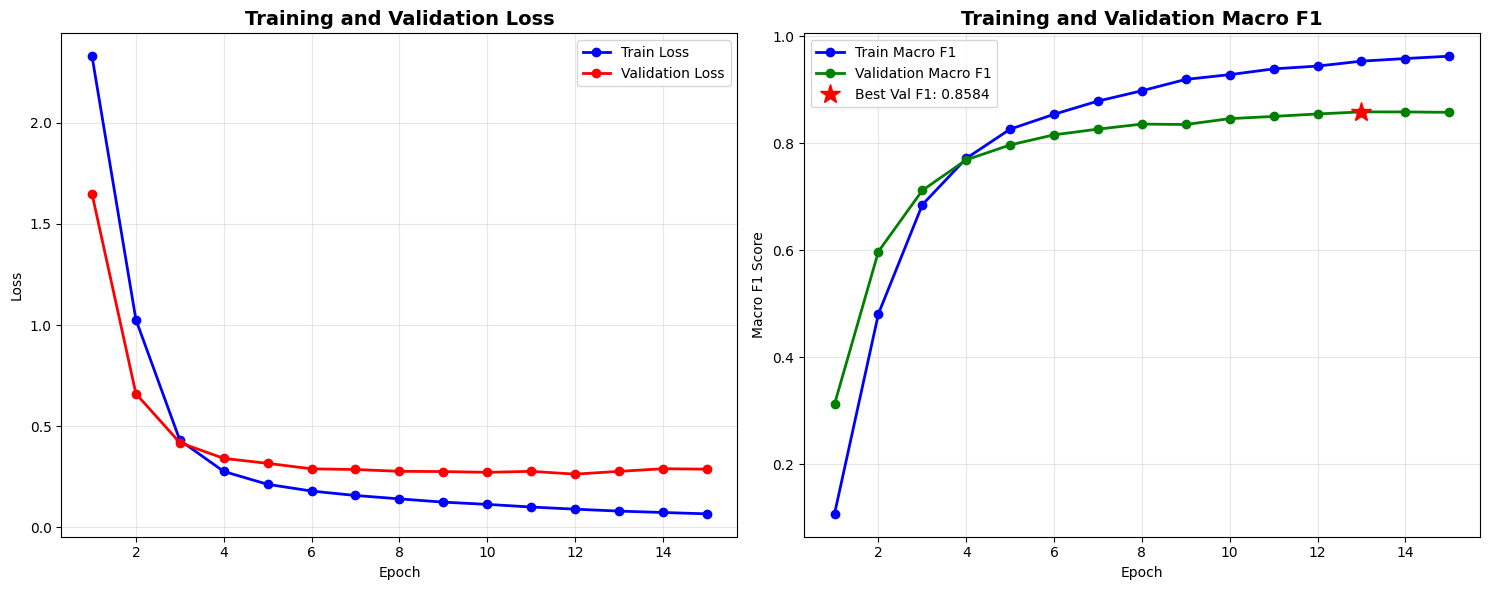

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# --- 1. CONFIG for CNN ---
config =   {
    "num_filters": 64,
    "n_layers": 4,
    "kernel_sizes": (2, 3, 4),   # use odd sizes to avoid length mismatch issues
    "dropout": 0.33,
    "lr": 0.001,
    "weight_decay": 0.0001,
    "batch_size": 512,
}

# --- 2. MODEL ---
vocab_size = len(word2id)
num_tags   = len(tag2id)
pad_idx    = word2id["<pad>"]
emb_dim    = embedding_weights.shape[1]

model = StackedCNNTagger(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    emb_weights=embedding_weights,
    num_filters=config["num_filters"],
    kernel_sizes=config["kernel_sizes"],
    num_layers=config["n_layers"],
    dropout=config["dropout"],
    num_tags=num_tags,
    pad_idx=pad_idx,
).to(device)

# --- 3. OPTIMIZER ---
optimizer = Adam(
    model.parameters(),
    lr=config["lr"],
    weight_decay=config["weight_decay"],
)

# --- 4. DATA LOADERS ---
train_loader = DataLoader(
    train_dataset_rnn,
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=collate_fn,
)
dev_loader = DataLoader(
    dev_dataset_rnn,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset_rnn,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=collate_fn,
)

# --- 5. CRITERION ---
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_ID)

# --- 6. TRAIN ---
history_final = train_model(
    model,
    train_loader,
    dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=15,
    save_path="ULTIMATE_MODEL.pt",
    clip_value=1.0,
)

# --- 7. PLOT ---
print("Training finished. Plotting results...")
plot_training_history(history_final)


In [ ]:
run_full_evaluation(model, train_loader, dev_loader, test_loader, criterion, num_tags, id2tag)


My Model -> Train
Classification report
              precision     recall   f1-score    support
-------------------------------------------------------
ADJ                0.98       0.98       0.98        N/A
ADP                0.99       0.98       0.98        N/A
ADV                0.96       0.97       0.97        N/A
AUX                1.00       1.00       1.00        N/A
CCONJ              1.00       1.00       1.00        N/A
DET                0.99       1.00       1.00        N/A
INTJ               0.99       0.92       0.95        N/A
NOUN               0.99       0.99       0.99        N/A
NUM                1.00       1.00       1.00        N/A
PART               1.00       1.00       1.00        N/A
PRON               1.00       1.00       1.00        N/A
PROPN              0.99       0.97       0.98        N/A
PUNCT              1.00       1.00       1.00        N/A
SCONJ              0.97       0.95       0.96        N/A
SYM                0.99       0.97       0.98   

Baseline Classifiers (Majority Classifier)

In [ ]:
word_tag_counts = defaultdict(Counter)
global_tag_counts = Counter()

for sent in train_sents:
    for w, t in sent:
        w = w.lower()
        word_tag_counts[w][t] += 1
        global_tag_counts[t]  += 1

most_common_tag = global_tag_counts.most_common(1)[0][0]

def baseline_tag(word):
    w = word.lower()
    if w in word_tag_counts:
        return word_tag_counts[w].most_common(1)[0][0]
    else:
        return most_common_tag
def eval_baseline(sentences, tag2id):
    y_true, y_pred = [], []
    for sent in sentences:
        for w, t in sent:
            y_true.append(tag2id[t])
            y_pred.append(tag2id[baseline_tag(w)])
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred
##########
from sklearn.metrics import classification_report, precision_recall_fscore_support, average_precision_score

def evaluate_baseline_classifier(sentences, tag2id, id2tag):
    y_true, y_pred = eval_baseline(sentences, tag2id)
    tag_names = [id2tag[i] for i in range(len(id2tag))]

    print("Classification report")
    print(classification_report(y_true, y_pred, target_names=tag_names, zero_division=0))

    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    print(f"Macro Precision: {macro_p:.4f}")
    print(f"Macro Recall:    {macro_r:.4f}")
    print(f"Macro F1:        {macro_f1:.4f}")

    num_tags = len(id2tag)
    pr_aucs = []
    probs_dummy = np.zeros((len(y_true), num_tags))
    for i in range(len(y_pred)):
        probs_dummy[i, y_pred[i]] = 1.0

    for c in range(num_tags):
        y_bin = (y_true == c).astype(int)
        pr_auc_c = average_precision_score(y_bin, probs_dummy[:, c])
        pr_aucs.append(pr_auc_c)

    print("\nPer-tag PR-AUC:")
    for i, auc in enumerate(pr_aucs):
        print(f"{id2tag[i]:>6}: {auc:.4f}")
    print(f"\nMacro PR-AUC: {np.mean(pr_aucs):.4f}")

    return {
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "per_tag_pr_auc": pr_aucs,
        "macro_pr_auc": float(np.mean(pr_aucs)),
    }

print("Baseline -> Train ")
baseline_train_metrics = evaluate_baseline_classifier(train_sents, tag2id, id2tag)
print("\nBaseline -> Dev ")
baseline_dev_metrics = evaluate_baseline_classifier(dev_sents, tag2id, id2tag)
print("\nBaseline -> Test ")
baseline_test_metrics = evaluate_baseline_classifier(test_sents, tag2id, id2tag)



Baseline -> Train 
Classification report
              precision    recall  f1-score   support

         ADJ       0.91      0.93      0.92     13155
         ADP       0.86      0.88      0.87     17791
         ADV       0.92      0.80      0.85     10104
         AUX       0.92      0.90      0.91     12814
       CCONJ       0.98      1.00      0.99      6688
         DET       0.96      0.98      0.97     16300
        INTJ       0.96      0.76      0.85       695
        NOUN       0.92      0.94      0.93     34803
         NUM       0.95      1.00      0.97      4127
        PART       0.71      0.99      0.83      5748
        PRON       0.97      0.92      0.95     18661
       PROPN       0.95      0.86      0.90     12620
       PUNCT       0.99      1.00      0.99     23597
       SCONJ       0.65      0.62      0.63      3822
         SYM       0.89      0.82      0.86       721
        VERB       0.91      0.89      0.90     22577
           X       0.79      0.51      0